<a href="https://colab.research.google.com/github/ozgenurunlu/Patika.dev-Assignments/blob/main/trafikkazalar%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
daveianhickey_2000_16_traffic_flow_england_scotland_wales_path = kagglehub.dataset_download('daveianhickey/2000-16-traffic-flow-england-scotland-wales')

print('Data source import complete.')


In [ ]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load dataset
df=pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv")
df.head(5)

/tmp/ipykernel_36/2396577433.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv")


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,201201BS70001,527200,178760,-0.169101,51.493429,1,3,2,1,19/01/2012,...,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002821,2012
1,201201BS70002,524930,181430,-0.200838,51.517931,1,3,2,1,04/01/2012,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01004760,2012
2,201201BS70003,525860,178080,-0.188636,51.487618,1,3,2,1,10/01/2012,...,non-junction pedestrian crossing,Daylight: Street light present,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002893,2012
3,201201BS70004,524980,181030,-0.200259,51.514325,1,3,1,1,18/01/2012,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002886,2012
4,201201BS70005,526170,179200,-0.183773,51.497614,1,3,1,1,17/01/2012,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002890,2012


# Gereksiz Sütunları Temizleme

**Çıkarılacak sütunlar:**

Accident_Index

Location_Easting_OSGR

Location_Northing_OSGR

Longitude

Latitude

Did_Police_Officer_Attend_Scene_of_Accident

LSOA_of_Accident_Location

In [ ]:
# Gereksiz sütunları çıkart
df = df.drop([
    'Accident_Index',
    'Location_Easting_OSGR', 'Location_Northing_OSGR',
    'Longitude', 'Latitude',
    'LSOA_of_Accident_Location',
    'Did_Police_Officer_Attend_Scene_of_Accident',
    'Special_Conditions_at_Site',
    'Carriageway_Hazards',
    'Junction_Detail'
], axis=1)

In [ ]:
# Tarih ve zaman dönüşümü
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Hour'] = df['Time'].str[:2].replace(':', '', regex=True).astype('float')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Hafta sonu mu? Cumartesi (5) veya Pazar (6) ise True
df['IsWeekend'] = df['Date'].dt.weekday >= 5


In [ ]:
#Eksik veri analizi
print("Missing values:")
print(df.isnull().sum())

Missing values:
Police_Force                                    0
Accident_Severity                               0
Number_of_Vehicles                              0
Number_of_Casualties                            0
Date                                            0
Day_of_Week                                     0
Time                                           13
Local_Authority_(District)                      0
Local_Authority_(Highway)                       0
1st_Road_Class                                  0
1st_Road_Number                                 0
Road_Type                                       0
Speed_limit                                     0
Junction_Control                           178610
2nd_Road_Class                                  0
2nd_Road_Number                                 0
Pedestrian_Crossing-Human_Control               0
Pedestrian_Crossing-Physical_Facilities         0
Light_Conditions                                0
Weather_Conditions                

In [ ]:
# Önemli sütunlarda boş veri bulunan satırları sil
df.dropna(subset=['Hour', 'Weather_Conditions', 'Road_Surface_Conditions','Light_Conditions','Junction_Control'], inplace=True)

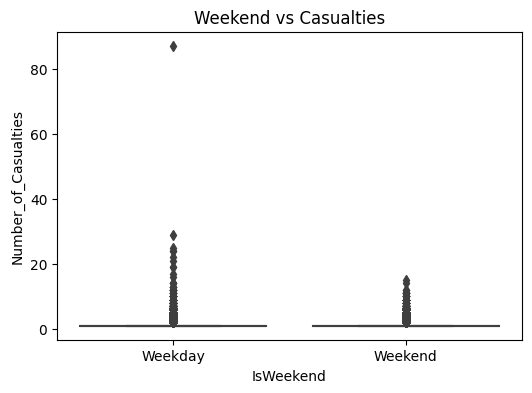

In [ ]:
# EDA - Haftaiçi Etkisi
plt.figure(figsize=(6,4))
sns.boxplot(x='IsWeekend', y='Number_of_Casualties', data=df)
plt.title("Weekend vs Casualties")
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.show()

1.Trafik akışının değişmesi kazaları nasıl etkiler?

Elimizde doğrudan bir “trafik yoğunluğu” metriği olmasa da bunu bazı dolaylı değişkenlerle modelleyebiliriz

Saat bilgisi: Trafik yoğunluğu genellikle sabah ve akşam zirvededir.

Haftanın günü: Hafta içi iş trafiği vs. hafta sonu rahatlığı.

Yol tipi: A yolları (ana yollar) daha yoğundur.

Urban/Rural: Kentsel bölgeler genellikle daha yoğun trafiğe sahiptir.

# ÇIKARIMLAR
**1.Saat ve Gün Bazlı Ortalama Kaza Sayısı**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


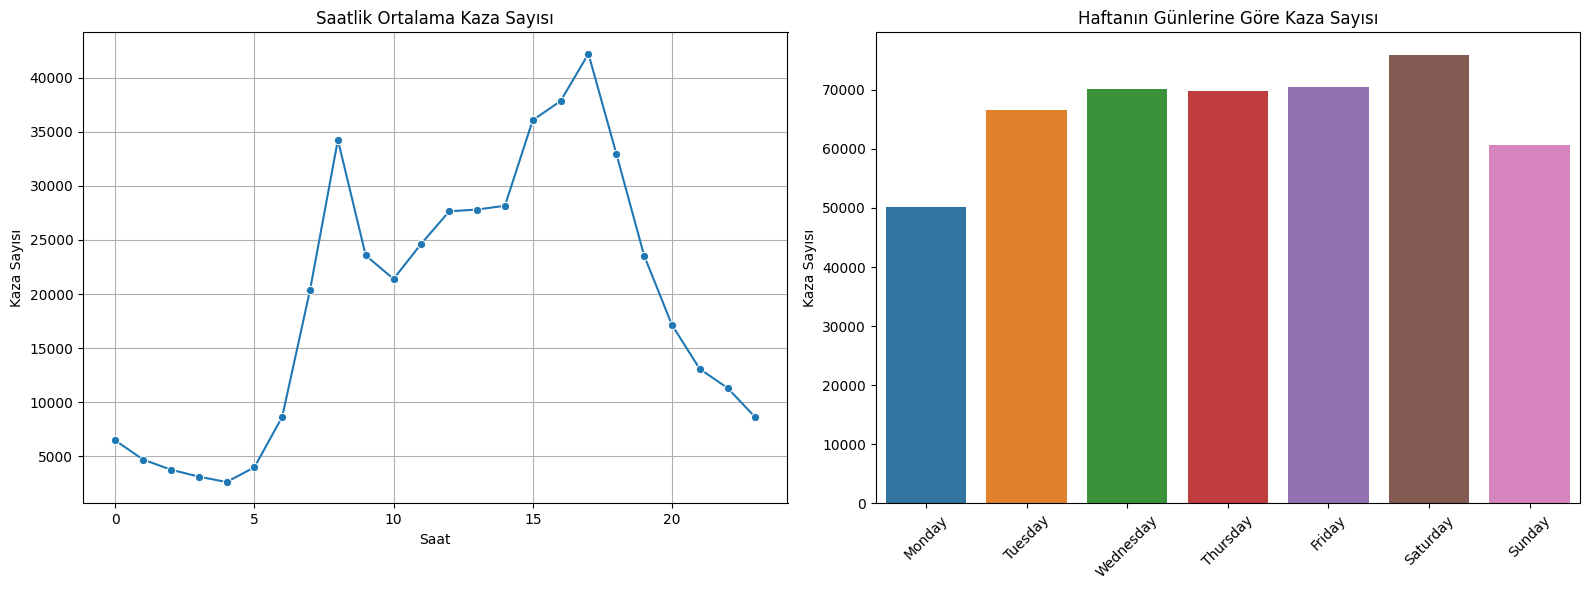

In [ ]:

# Saatlik ortalama kaza sayısı
hourly_accidents = df.groupby("Hour").size()

# Haftalık ortalama
weekday_accidents = df.groupby("Day_of_Week").size()

# Görselleştirme
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=hourly_accidents.index, y=hourly_accidents.values, marker="o")
plt.title("Saatlik Ortalama Kaza Sayısı")
plt.xlabel("Saat")
plt.ylabel("Kaza Sayısı")
plt.grid(True)

plt.subplot(1, 2, 2)
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x=days, y=weekday_accidents.values)
plt.title("Haftanın Günlerine Göre Kaza Sayısı")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sabah 7–9 ve akşam 16–19 saatleri arasında kaza sayılarında artış var.

Bu trafik yoğunluğunun arttığı saatlerde kaza olasılığı arttı demektir.

**2.Yol Tipine Göre Kaza Yoğunluğu**

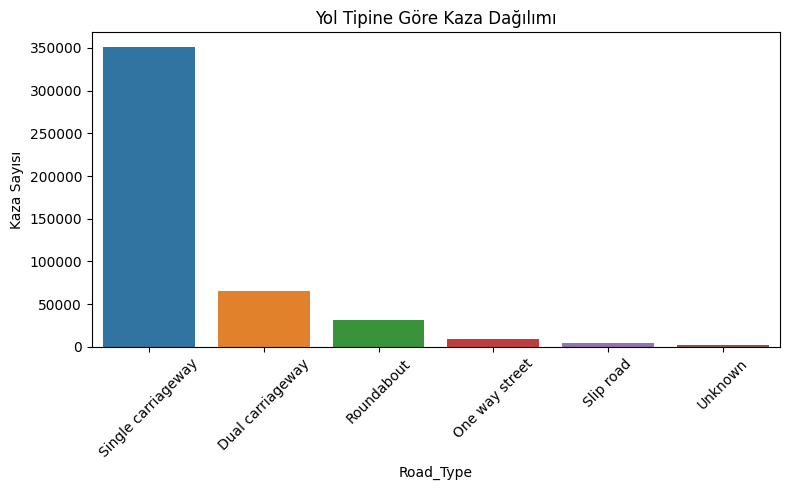

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Road_Type", order=df["Road_Type"].value_counts().index)
plt.title("Yol Tipine Göre Kaza Dağılımı")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**3.Kaza şiddetini ne artırır?**

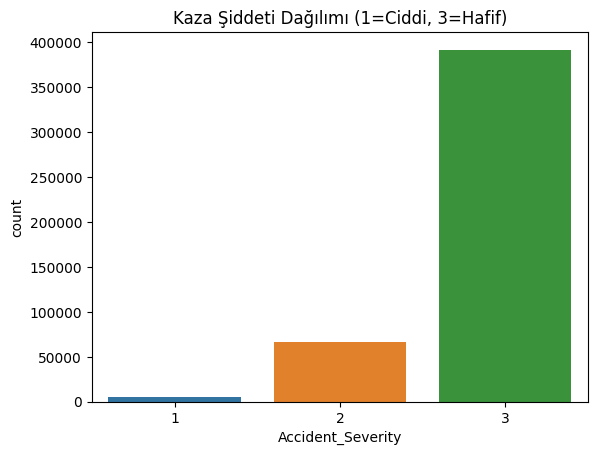

In [ ]:
# Şiddet derecesi dağılımı
sns.countplot(data=df, x="Accident_Severity", order=[1, 2, 3])
plt.title("Kaza Şiddeti Dağılımı (1=Ciddi, 3=Hafif)")
plt.show()

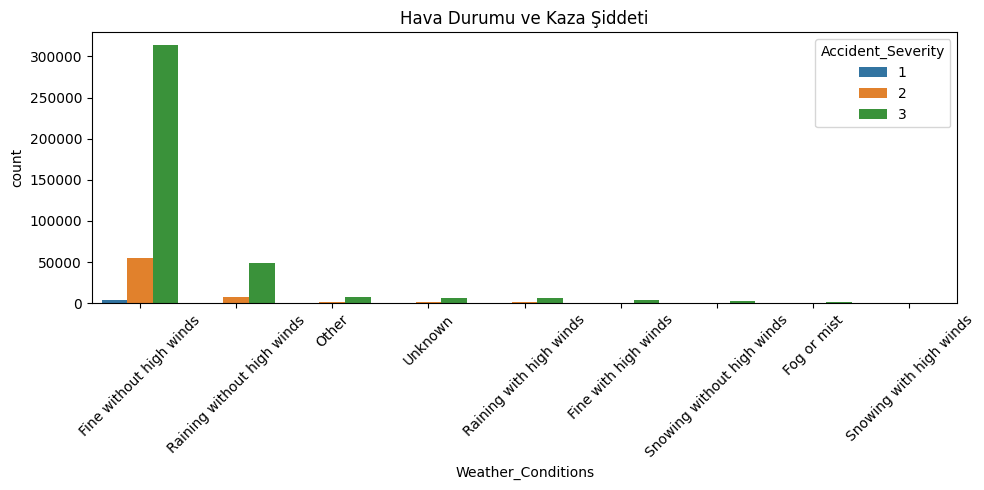

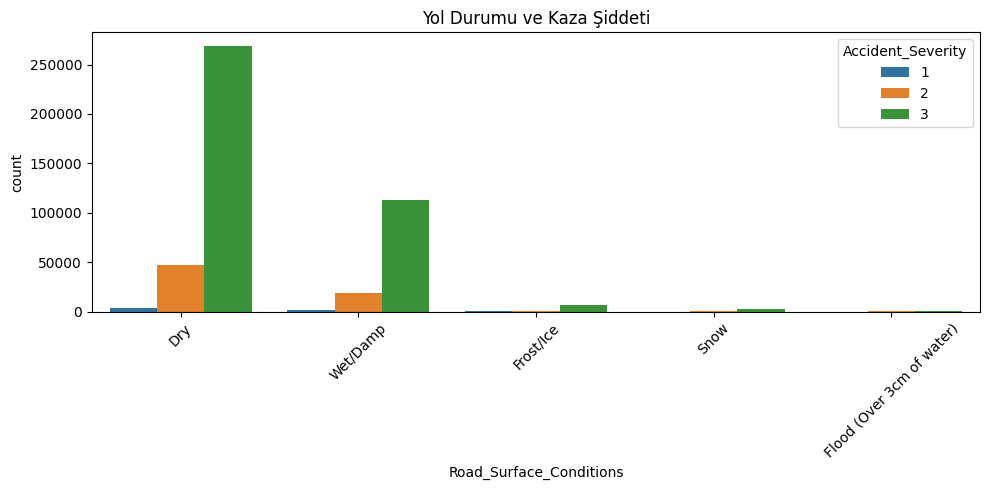

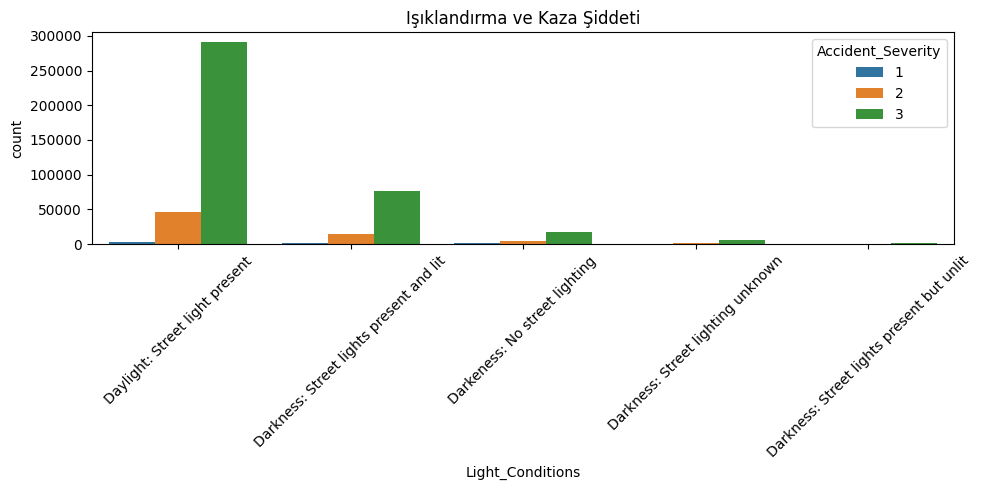

In [ ]:
# Hava durumu ve kaza şiddeti
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Weather_Conditions", hue="Accident_Severity", order=df["Weather_Conditions"].value_counts().index)
plt.title("Hava Durumu ve Kaza Şiddeti")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Yol yüzeyi ve şiddet
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Road_Surface_Conditions", hue="Accident_Severity", order=df["Road_Surface_Conditions"].value_counts().index)
plt.title("Yol Durumu ve Kaza Şiddeti")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Aydınlatma ve şiddet
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Light_Conditions", hue="Accident_Severity", order=df["Light_Conditions"].value_counts().index)
plt.title("Işıklandırma ve Kaza Şiddeti")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**4.Kırsal ve kentsel alanlar nasıl farklılaştı?**

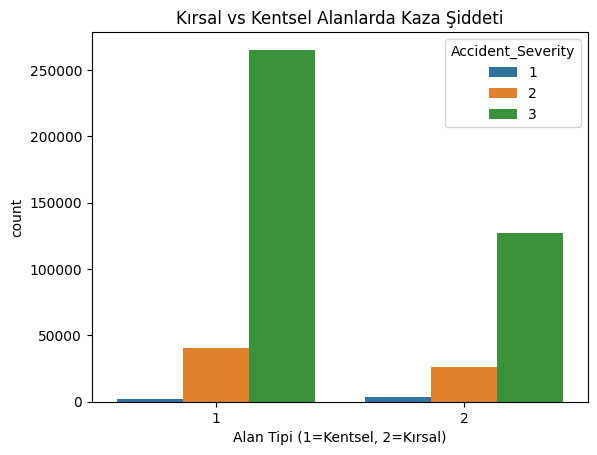

In [ ]:
sns.countplot(data=df, x="Urban_or_Rural_Area", hue="Accident_Severity")
plt.title("Kırsal vs Kentsel Alanlarda Kaza Şiddeti")
plt.xlabel("Alan Tipi (1=Kentsel, 2=Kırsal)")
plt.show()

Kentsel alanlarda daha çok kaza olur çünkü yoğunluk fazladır.

Ancak kırsal bölgelerde kaza az ama daha ölümcül olabilir çünkü hız yüksektir ve yardım gecikir.

**5. Kavşak noktasında kaza oranı yüksek mi?**

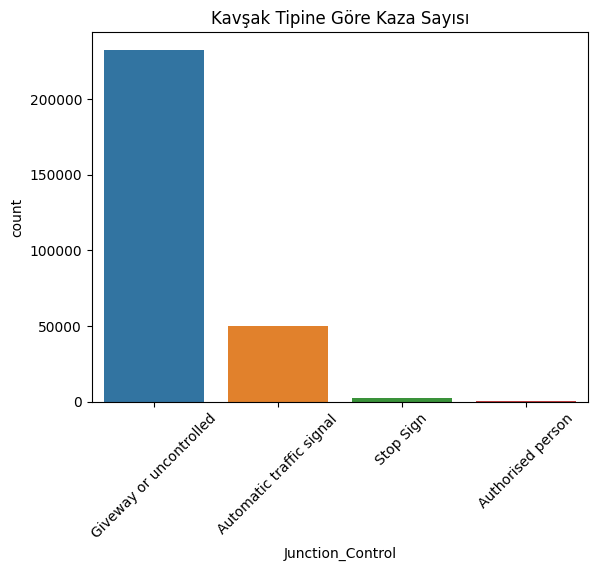

In [ ]:
sns.countplot(data=df, x="Junction_Control", order=df["Junction_Control"].value_counts().index)
plt.title("Kavşak Tipine Göre Kaza Sayısı")
plt.xticks(rotation=45)
plt.show()